# RLC - Baseline Meta-Curvature
Notebook to run experiments on the RLC circuit dataset.

Before running this notebook, you need to run the pretraining run. To do so, execute the following command from the repository root directory:
`python tsfewshot/run_scheduler.py train --directory experiments/nl-rlc/configs/ --runs-per-gpu 4 --gpu-ids 0` or `python tsfewshot/run.py train --config-file experiments/nl-rlc/configs/metacurv-config.yml --gpu 0`

The first will run all config files in the specified directory, with 4 runs in parallel on GPU 0, the latter only the Meta-Curvature pretraining run.

In [13]:
%load_ext autoreload
%autoreload 2
import pickle
import sys
from collections import defaultdict
from pathlib import Path

from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', datefmt='%I:%M:%S')

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import scipy
import torch
import os
from tqdm import tqdm

sys.path.append('../..')
from tsfewshot.config import Config
from tsfewshot import plot, analyses

np.random.seed(0)
torch.random.manual_seed(0)

DEVICE = 'cuda:0'
SUPPORT_SIZES = [10, 20, 30, 50, 70, 100]
QUERY_SIZE = 2000

CODE_DIR = Path('../..')
DATA_DIR = 'experiments/nl-rlc/data/rlc_dataset-resistor_range1_14-capacitor_range100_800-inductor_range20_140'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# get the run directories from the meta-training phase
RUN = Path('runs/meta_curvature/rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730').resolve()

In [15]:
# create tasks on which we will generate the finetuning trajectories that
# will be used to calculate the preconditioning matrix
finetune_tasks = sorted(f'val/{d.name}' for d in (Path(DATA_DIR) / 'val').glob('*.npy'))
len(finetune_tasks)

512

In [16]:
ft_epochs = defaultdict(lambda: 500)

eval_every = list(range(20)) + list(range(20, 501, 20))
inner_seeds = [0]

type_specs = [
    'normal',  # SGD finetuning
    # 'pca',  # our method
]

gridsearch_dir = 'optimizeFinetune'

def combinations():
    combinations = []
    for type_spec in type_specs:
        if 'pca' in type_spec:
            lrs = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]  
        elif 'normal' in type_spec:
            lrs = [1e-2, 1e-3, 1e-4, 1e-5]
        elif 'jfr' in type_spec:
            lrs = [1.0] # dummy, this adaption method does not use gradient descent, hence no lr
        for lr in lrs:
            for support in SUPPORT_SIZES:
                combinations.append({'support': support,
                                     'lr': lr,
                                     'type': type_spec,
                                     'noise': 0.0,
                                     'sparsity': None,
                                     'pca_interpolate': 1.0,
                                    })
    return combinations
    
len(combinations())

24

In [17]:
# create gridsearch for optimal learning rate and number of update steps during finetuning.
new_runs = analyses.create_gridsearch_dirs(RUN,
                                            combinations(),
                                            gridsearch_dir,
                                            inner_seeds,
                                            n_trajectories=-1,
                                            query_size=QUERY_SIZE,
                                            ft_epochs=ft_epochs,
                                            eval_every=eval_every,
                                            save_predictions=True,
                                            optimizer='sgd-squared',
                                            val_datasets=finetune_tasks[::2], # gridsearch on half of the finetune_tasks
                                            init_epoch=None, # uses best epoch
                                            pca_file_path=RUN / 'pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNonelayerwiseFalse.p')

[r.name for r in new_runs]

100%|██████████| 24/24 [00:00<00:00, 6891.91it/s]


[]

Next, run the created gridsearch configurations via:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune/ --epoch -1 --split val --gpu-ids 0 --runs-per-gpu 5`.

In [18]:
best_ft_options = {}
best_ft_epochs = {}
gridsearch_results = {}

In [19]:
# load the gridsearch results and calculate the best learning rate and number of update steps
# for each support size and each method.
# For the best configuration of each support size and method, we create a final finetuning experiment
# that we'll use to analyze the results.
test_tasks = sorted(f'test/{d.name}' for d in (Path(DATA_DIR) / 'test').glob('*.npy'))
new_run_dirs, best_ft_options, best_ft_epochs, gridsearch_results = \
    analyses.create_final_finetune_dirs([RUN],
                                          SUPPORT_SIZES,
                                          combinations(),
                                          inner_seeds,
                                          gridsearch_dir,
                                          test_tasks,
                                          best_ft_options=best_ft_options,
                                          best_ft_epochs=best_ft_epochs,
                                          n_results=256,
                                          metric_aggregation='median',
                                          metric_name='mse')
[r.name for r in new_run_dirs]

10
20
30
50
70
100
support size: 10   normal noise 0.0                                                                 LR: 0.0001 epochs: 220  interpolate: 1.0
support size: 20   normal noise 0.0                                                                 LR: 0.0001 epochs: 240  interpolate: 1.0
support size: 30   normal noise 0.0                                                                 LR: 0.0001 epochs: 180  interpolate: 1.0
support size: 50   normal noise 0.0                                                                 LR: 0.0001 epochs: 300  interpolate: 1.0
support size: 70   normal noise 0.0                                                                 LR: 0.0001 epochs: 220  interpolate: 1.0
support size: 100  normal noise 0.0                                                                 LR: 1e-05  epochs: 440  interpolate: 1.0


['support10_lr0.0001_normal_sparseNone_noise0.0_seed0_pcainterpolate1.0',
 'support20_lr0.0001_normal_sparseNone_noise0.0_seed0_pcainterpolate1.0',
 'support30_lr0.0001_normal_sparseNone_noise0.0_seed0_pcainterpolate1.0',
 'support50_lr0.0001_normal_sparseNone_noise0.0_seed0_pcainterpolate1.0',
 'support70_lr0.0001_normal_sparseNone_noise0.0_seed0_pcainterpolate1.0',
 'support100_lr1e-05_normal_sparseNone_noise0.0_seed0_pcainterpolate1.0']

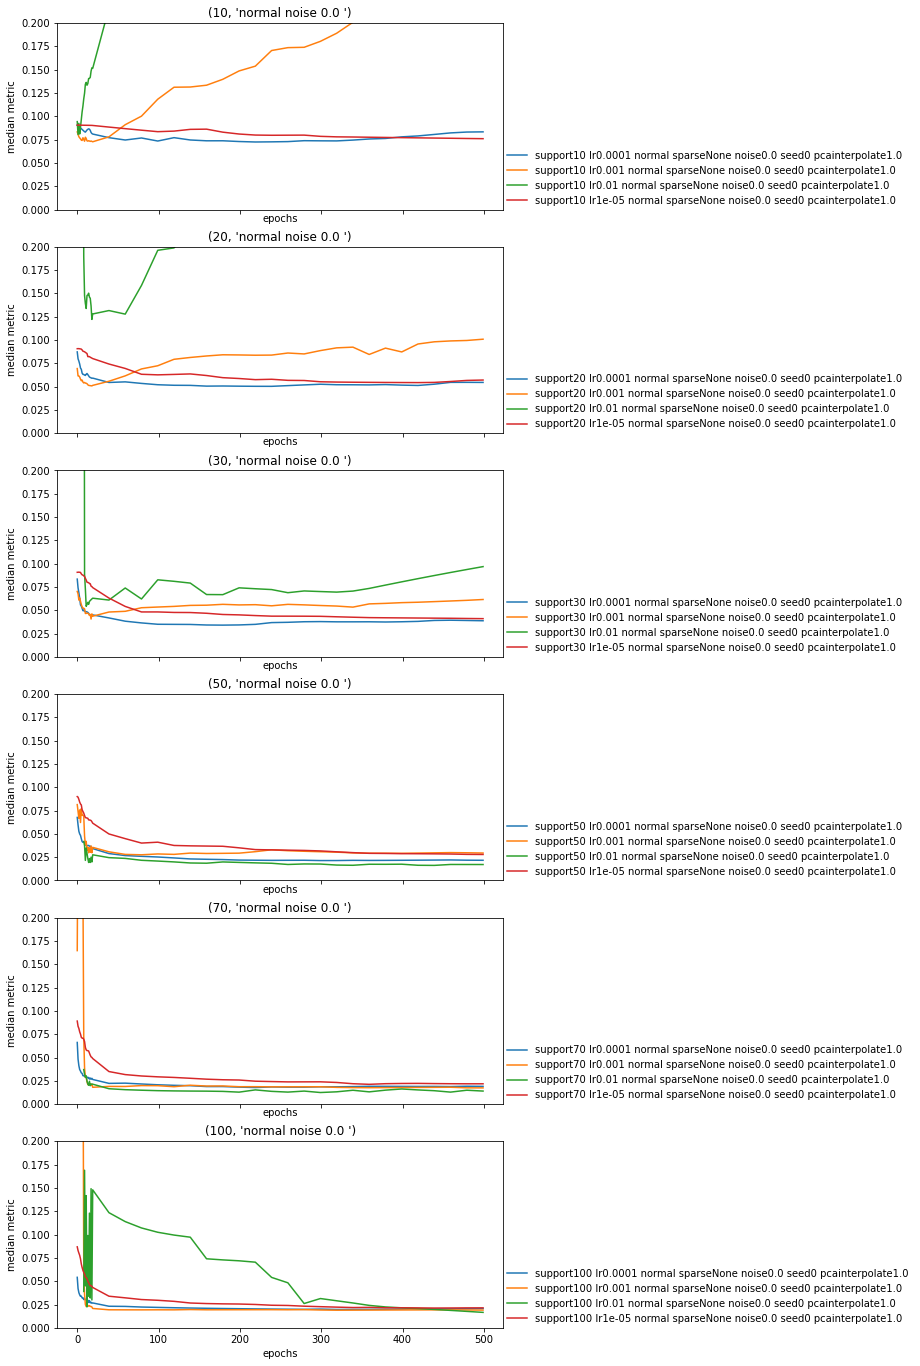

In [20]:
_ = plot.plot_gridsearch(gridsearch_results)
_ = plt.ylim(0.0, 0.2)

Next, run the final finetuning experiments:
`python tsfewshot/run_scheduler.py eval --directory /path/to/run/optimizeFinetune_finalFinetune/ --epoch -1 --split test --gpu-ids 0 --runs-per-gpu 5`.

In [22]:
# load the result from final finetuning
metrics = None
metrics = analyses.get_final_metrics([RUN],
                                     noises=[0.0],
                                     support_sizes=SUPPORT_SIZES,
                                     combinations=combinations(),
                                     best_ft_options=best_ft_options,
                                     inner_seeds=inner_seeds,
                                     query_size=QUERY_SIZE,
                                     n_trajectories=-1,
                                     test_tasks=test_tasks,
                                     gridsearch_dir=gridsearch_dir,
                                     init_epoch=None,
                                     metrics=metrics,
                                     metric_name='mse',
                                     metric_file_name='mse_rmse',
                                     metric_aggregation='median',
                                     n_dataset_evals = None,
                                     no_ft_eval=True)

Predict:   0%|          | 0/256 [00:00<?, ?it/s, test/R:1.0249437636881251_L:0.00010726452771948082_C:2.643912032291413e-07.npy] 

site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


Metrics: 100%|██████████| 256/256 [01:14<00:00,  3.43it/s, test/R:9.983958501079368_L:0.00012584403497848943_C:3.6199947143222183e-07.npy]  
10
20
30
50
70
100


In [23]:
# dump results so we don't have to recalculate each time we run this notebook
pickle.dump(metrics, (RUN / 'metrics.p').open('wb'))
pickle.dump(best_ft_options, (RUN / 'best_ft_options.p').open('wb'))
pickle.dump(best_ft_epochs, (RUN / 'best_ft_epochs.p').open('wb'))

In [24]:
# load metrics when re-executing the notebook, so we don't have to recalculate
metrics = pickle.load((RUN / 'metrics.p').open('rb'))
best_ft_options = pickle.load((RUN / 'best_ft_options.p').open('rb'))
best_ft_epochs = pickle.load((RUN / 'best_ft_epochs.p').open('rb'))

In [25]:
df_norms = pd.DataFrame({k: v['mse'] for k, v in metrics[0.0].items()}, dtype=float)
df_norms.columns.names = ['support', 'type', 'seed']

# results table
display_df = df_norms.copy()
median = display_df.median(axis=0)
mean = display_df.mean(axis=0)
display_df.loc[' rank'] = display_df.groupby('support', axis=1).rank(axis=1).median(axis=0)
display_df.loc[' median'] = median
display_df.loc[' mean'] = mean
display(display_df.sort_index().style.background_gradient('Greens_r', axis=1).highlight_null('white'))

site-packages/pandas/io/formats/style.py:1268: RuntimeWarning: invalid value encountered in double_scalars
  norm = colors.Normalize(smin - (rng * low), smax + (rng * high))
site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


support,10,20,30,50,70,100,10,20,30,50,70,100
type,no-finetune,no-finetune,no-finetune,no-finetune,no-finetune,no-finetune,normal noise 0.0,normal noise 0.0,normal noise 0.0,normal noise 0.0,normal noise 0.0,normal noise 0.0
seed,"('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)","('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)","('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)","('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)","('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)","('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)","('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)","('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)","('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)","('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)","('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)","('rlc-ode-3trtraj-meta_curvature-50support6batch5steplr0.001innerlr0.0001-finetune5-seed1_220419_184730', 0)"
mean,0.111849,0.111849,0.111849,0.111849,0.111849,0.111849,0.104799,0.085506,160.911079,255.789671,inf,524.184302
median,0.073373,0.073373,0.073373,0.073373,0.073373,0.073373,0.061741,0.037654,0.029476,0.020483,0.017851,0.017417
rank,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
test/R:1.0249437636881251_L:0.00010726452771948082_C:2.643912032291413e-07.npy,0.520644,0.520644,0.520644,0.520644,0.520644,0.520644,0.518612,0.506809,0.618518,0.756246,0.569678,2.174938
test/R:1.1586005688888497_L:8.693189183448564e-05_C:2.7407460137915236e-07.npy,0.240706,0.240706,0.240706,0.240706,0.240706,0.240706,0.247944,0.204970,0.365352,0.064060,0.585776,0.129545
test/R:1.1970406984962436_L:4.581432462508986e-05_C:3.8705381297963926e-07.npy,0.218560,0.218560,0.218560,0.218560,0.218560,0.218560,0.202366,0.242007,0.227204,0.184087,0.778102,0.100644
test/R:1.332428795631129_L:3.301060869307106e-05_C:4.700441470380736e-07.npy,0.063298,0.063298,0.063298,0.063298,0.063298,0.063298,0.034872,0.023230,0.023105,0.021994,0.022097,0.025372
test/R:1.3402772427181766_L:4.746310122094462e-05_C:4.956053200425364e-07.npy,0.059903,0.059903,0.059903,0.059903,0.059903,0.059903,0.168844,0.116970,0.044464,0.053582,0.042992,0.019289


In [28]:

from matplotlib import rc
rc('text', usetex=True)

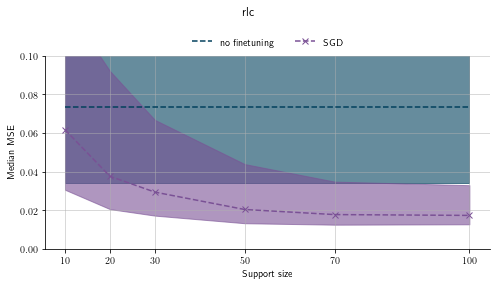

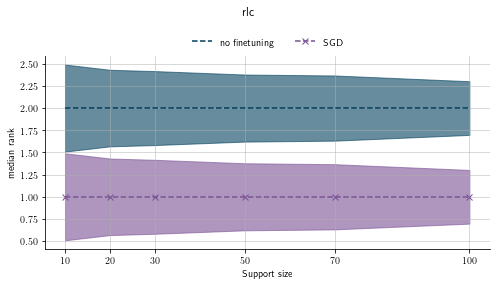

In [29]:
# plot results
figsize = (7,4)
f = plot.plot_support_vs_mse(df_norms,
                             SUPPORT_SIZES,
                             ranks=False,
                             figsize=figsize,
                             aggregation='median',
                             title='rlc', 
                             exclude_types=[],
                             metric_name='MSE')
plt.ylim(0,0.1)
f2 = plot.plot_support_vs_mse(df_norms,
                              SUPPORT_SIZES,
                              ranks=True,
                              figsize=figsize,
                              title='rlc')

In [7]:
# significance test
from scipy.stats import wilcoxon
p = {}
noise = 0.0
sig_df = df_norms.groupby(['support', 'type'], axis=1).agg(lambda s: s.mean(skipna=False))
best_typs = {support: sig_df.loc[:, support].mean().idxmin(axis=1) for support in SUPPORT_SIZES}
for support, typ in sig_df.columns:
    if typ == f'{best_typs[support]} noise 0.0 ':
        p[(support, typ)] = np.nan
        continue
    if ((sig_df.loc[:, (support, typ)] - sig_df.loc[:, (support, best_typs[support])]) == 0).all():
        p[(support, typ)] = np.nan
        continue
    p[(support, typ)] = wilcoxon(sig_df.loc[:, (support, typ)], sig_df.loc[:, (support, best_typs[support])])[1]
sig_df = pd.DataFrame(p, index=['p-value']).T
sig_df.index.names = ['support', 'type']
display(sig_df.reset_index().pivot(index='type', columns='support', values='p-value').style.format('{:.3e}'))

support,10,20,30,50,70,100
type,,,,,,
no-finetune,5.026e-06,3.054e-16,nan,nan,nan,nan
normal noise 0.0,1.458e-04,nan,1.449e-26,1.967e-31,1.372e-26,1.982e-24
pca noise 0.0,nan,1.611e-01,5.537e-25,3.956e-32,6.399e-30,9.368e-25


In [ ]:
# Plot eigenvalue distribution
pca = pickle.load((RUN / 'pca/pca-torchcenterFalseNonecomponentspathNoneimprovedFalseusestepsNonelayerwiseFalse.p').open('rb'))
eigenvalues = pca['s']**2 / (pca['u'].shape[0] - 1)
plt.plot(eigenvalues)
plt.ylabel('Eigenvalue')
plt.xlabel('Component')
plt.grid(alpha=0.6)
plt.yscale('log')
plt.tight_layout()

In [ ]:
run = RUN
finetune_dirs = list((run / f'finetune_adam_epoch{init_epoch}').glob('rlc*/'))  # TODO init_epoch
cfg = Config(run / 'config.yml')
plt.figure(figsize=(14,7))
f, ax = plot.plot_deltas_rank(cfg, finetune_dirs,
                              tols=[0],
                              ax=plt.gca(),
                              random_baseline=True,
                              n_repeats=1,
                              task_steps=1,
                              within_task_steps=None,
                              epoch_steps=None,
                              use_erank=True,
                              init_epoch=-1,
                              plot_val_metric=False)
plt.xscale('log')
plt.tight_layout()